# Get Data with R Tools

First load up some packages we need.

In [1]:
library(sf)
library(dataRetrieval)
library(nhdplusTools)

Linking to GEOS 3.7.0, GDAL 2.4.0, PROJ 5.2.0
USGS Support Package: https://owi.usgs.gov/R/packages.html#support


Now set a start and end date and pick an NWIS site.

Use this mapper: https://maps.waterdata.usgs.gov/mapper/index.html to find a site or use the siteList function shown below. A HUC filter is useful here, you can find your HUC at this page: https://water.usgs.gov/wsc/map_index.html

In [6]:
discharge <- "00060"
start <- "2018-08-01"
end <- "2018-12-01"
huc <- "07060004"

siteList <- whatNWISsites(huc=c(huc), parameterCd=discharge, startDt=start, endDt=end)

siteList

agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,colocated,queryTime
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<dttm>
USGS,05411600,"Turkey River at Spillville, IA",ST,43.20728,-91.95033,FALSE,2019-06-12 16:21:51
USGS,05411850,"Turkey River near Eldorado, IA",ST,43.05419,-91.80910,FALSE,2019-06-12 16:21:51
USGS,05412020,"Turkey River above French Hollow Cr at Elkader, IA",ST,42.84349,-91.40128,FALSE,2019-06-12 16:21:51
USGS,05412400,"Volga River at Littleport, IA",ST,42.75388,-91.36903,FALSE,2019-06-12 16:21:51
USGS,05412500,"Turkey River at Garber, IA",ST,42.73999,-91.26180,FALSE,2019-06-12 16:21:51


Copy and paste a "site_no" value below.

In [8]:
site <- "05411600"

subset_gpkg <- file.path("temp_data", paste0(site, "_hydrography.gpkg")) 

site_meta <- dataRetrieval::readNWISsite(site)

site_meta <- st_as_sf(site_meta, coords = c("dec_long_va", "dec_lat_va"), crs = 4326)

In [9]:
nhdplusTools::discover_nldi_sources()

nldi_feature <- list(featureSource = "nwissite", 
                     featureID = paste0("USGS-", site))

flowline <- navigate_nldi(nldi_feature, 
                          mode = "upstreamTributaries", 
                          data_source = "")
try({
subset_nhdplus(comids = flowline$nhdplus_comid,
               output_file = subset_gpkg,
               nhdplus_data = "download")
    }, silent = TRUE)

flowline <- sf::read_sf(subset_gpkg, "NHDFlowline_Network")
catchment <- sf::read_sf(subset_gpkg, "CatchmentSP")
waterbody <- sf::read_sf(subset_gpkg, "NHDWaterbody")

siteList <- st_as_sf(siteList, coords = c("dec_long_va", "dec_lat_va"), crs = "+proj=longlat +datum=WGS84 +no_defs")


source,sourceName,features
<chr>,<chr>,<chr>
comid,NHDPlus comid,https://cida.usgs.gov/nldi/comid
huc12pp,HUC12 Pour Points,https://cida.usgs.gov/nldi/huc12pp
npdes_rad,EPA Office of Water (OW): Facilities that Discharge to Water NHDPlus Indexed Dataset,https://cida.usgs.gov/nldi/npdes_rad
nwissite,NWIS Sites,https://cida.usgs.gov/nldi/nwissite
wqp,Water Quality Portal,https://cida.usgs.gov/nldi/wqp


All intersections performed in latitude/longitude.
Reading NHDFlowline_Network
Writing NHDFlowline_Network
Reading CatchmentSP
Writing CatchmentSP


[1] "temp_data/05411600_hydrography.gpkg"

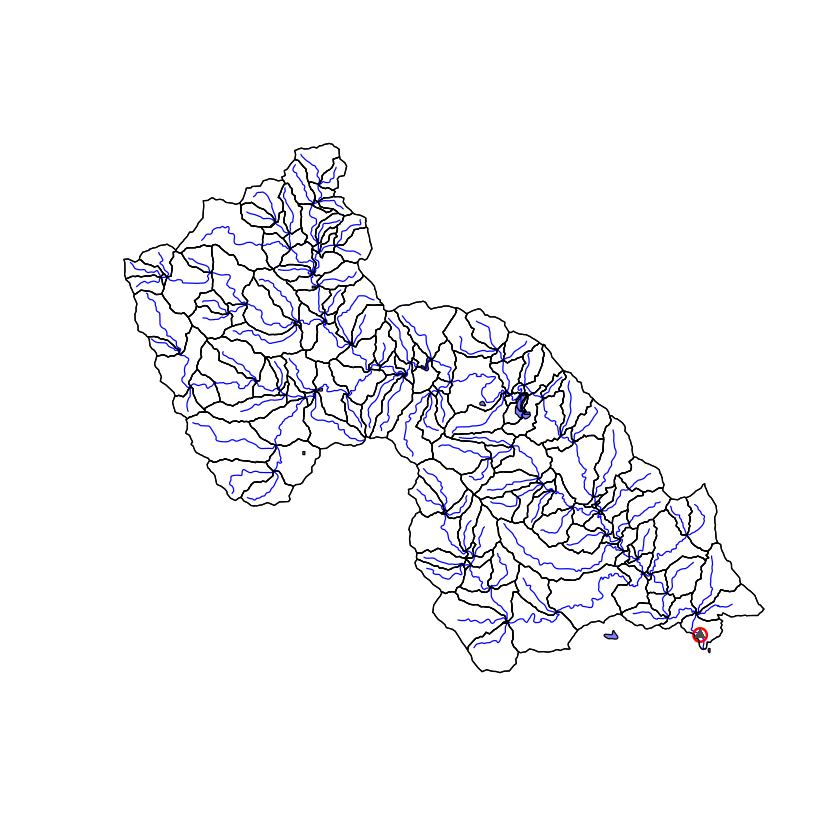

In [10]:
plot(sf::st_geometry(catchment))
plot(sf::st_geometry(flowline), col = "blue", add = TRUE)
plot(st_geometry(site_meta), cex = 1.5, lwd = 2, col = "red", add = TRUE)
plot(sf::st_geometry(catchment), add = TRUE)
plot(sf::st_geometry(waterbody), col = rgb(0, 0, 1, alpha = 0.5), add = TRUE)
plot(sf::st_geometry(siteList), col = "grey30", pch = 17, add = TRUE)

# For more see: https://usgs-r.github.io/nhdplusTools/articles/nhdplusTools.html

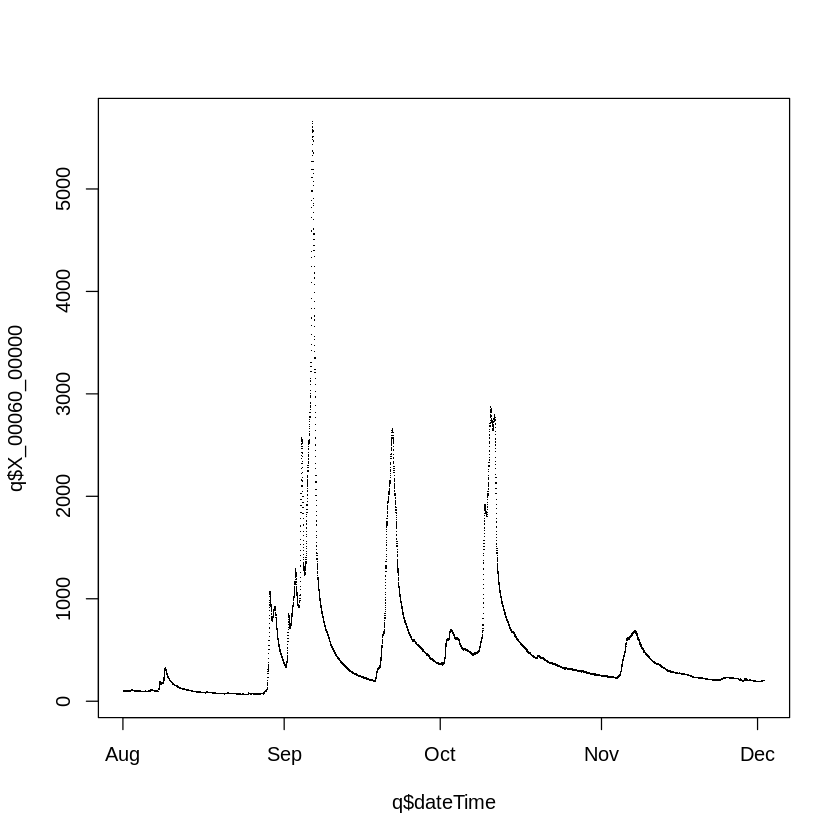

In [11]:
q <- readNWISuv(site, discharge, start, end)

plot(q$dateTime, q$X_00060_00000, pch = ".")

In [12]:
library(intersectr)
library(dplyr)
library(RNetCDF)

analysis_projection <- "+init=epsg:26915"
catchment <- catchment %>%
  st_transform(analysis_projection)

nc_source <- "http://thredds.northwestknowledge.net:8080/thredds/dodsC/MET/pr/pr_2018.nc"
nc <- open.nc(nc_source)
(nc_var <- ncmeta::nc_vars(nc))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



id,name,type,ndims,natts
<dbl>,<chr>,<chr>,<dbl>,<dbl>
0,lon,NC_DOUBLE,1,5
1,lat,NC_DOUBLE,1,5
2,day,NC_FLOAT,1,5
3,crs,NC_INT,1,7
4,precipitation_amount,NC_FLOAT,3,7


In [13]:
variable_name <- "precipitation_amount"
(nc_coord_vars <- ncmeta::nc_coord_var(nc, variable_name))

variable,X,Y,Z,T,bounds
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
precipitation_amount,lon,lat,NA,day,NA


In [14]:
x <- var.get.nc(nc, nc_coord_vars$X, unpack = TRUE)
y <- var.get.nc(nc, nc_coord_vars$Y, unpack = TRUE)
cell_geometry <- create_cell_geometry(X_coords = x, 
                                      Y_coords = y, 
                                      prj = ncmeta::nc_gm_to_prj(ncmeta::nc_grid_mapping_atts(nc)), 
                                      geom = catchment, 
                                      buffer_dist = 1000)

although coordinates are longitude/latitude, st_contains assumes that they are planar


In [15]:
data_source_cells <- st_sf(select(cell_geometry, grid_ids))
target_polygons <- st_sf(select(catchment, featureid))
st_agr(data_source_cells) <- "constant"
st_agr(target_polygons) <- "constant"

# Create the areal weights
area_weights <- 
  calculate_area_intersection_weights(data_source_cells, target_polygons)

In [16]:
intersected <- execute_intersection(nc_file = nc_source,
                                    variable_name = variable_name,
                                    intersection_weights = area_weights,
                                    cell_geometry = cell_geometry,
                                    x_var = nc_coord_vars$X, 
                                    y_var = nc_coord_vars$Y, 
                                    t_var = nc_coord_vars$T,
                                    start_datetime = paste(start, "00:00:00"),
                                    end_datetime = paste(end, "00:00:00"))

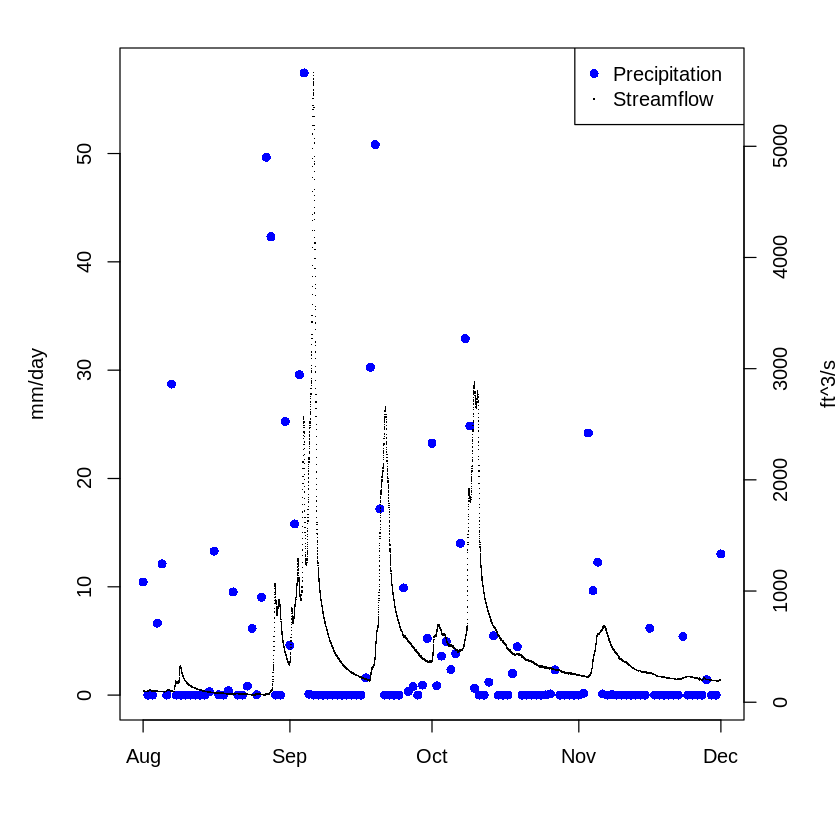

In [20]:
prcp_data <- select(intersected, -time_stamps)
#print(prcp_data)
mean_prcp <- rowMeans(prcp_data)
par(mar = c(5,5,2,4))
plot(intersected$time_stamps, mean_prcp, 
     xlab = NA, ylab = "mm/day", pch = 16, col = "blue")
par(new = T)
plot(q$dateTime, q$X_00060_00000, pch = ".", axes = FALSE, xlab = NA, ylab = NA)
axis(side = 4)
mtext(side = 4, line = 3, 'ft^3/s')
legend("topright",
       legend=c("Precipitation", "Streamflow"),
       pch=c(16, 46), col=c("blue", "black"))

Joining, by = "featureid"


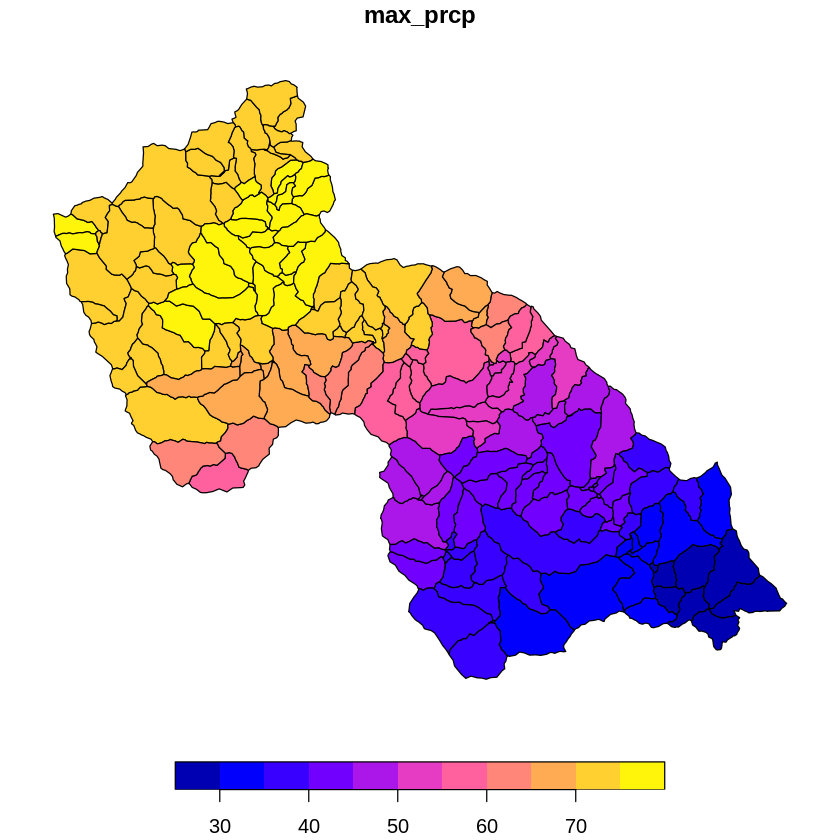

In [21]:
max_prcp <- tibble(featureid = as.integer(names(prcp_data)), 
                   max_prcp = as.numeric(filter(prcp_data, mean_prcp == max(mean_prcp))))

catchment <- left_join(catchment, max_prcp)

plot(catchment["max_prcp"])

In [22]:
readr::write_csv(intersected, "temp_data/precip_data.csv")
readr::write_csv(q, "temp_data/streamflow_data.csv")